In [14]:
import pandas as pd
import numpy as np
from utils import peek
import joblib
import pickle
import config

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgbm
import sklearn

from functools import partial
from scipy.optimize import fmin

In [46]:
train = pd.read_csv(config.TRAIN3)

In [48]:
param = {'num_iterations':384, 'learning_rate':0.009737861649027716, 'num_leaves':7,' max_depth':16, 'min_data_in_leaf':7
        ,'max_bin':400, 'min_data_in_bin':17, 'objective':'binary', 'feature_fraction':0.3, 'verbosity':0, 'force_col_wise':True,
         'linear_tree':True, 'seed':42}
valid_fold = 0
valid = train.query(f'fold == {valid_fold}')
train2 = train.query(f'fold != {valid_fold}')
train_x, train_y = train2.drop(['order_status_key', 'fold'], axis=1), train2['order_status_key']
dtrain = lgbm.Dataset(train_x, label=train_y)
clf = lgbm.train(param, dtrain, categorical_feature=['degree', 'card_num', 'gender'])
valid['score'] = clf.predict(valid_x)

/sda/software/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/sda/software/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['card_num', 'degree', 'gender']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/tmp/ipykernel_2433649/206555083.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['score'] = clf.predict(valid_x)


In [52]:
pos_wrong = valid.query('order_status_key == 1').sort_values('score')[:30]

In [55]:
neg_wrong = valid.query('order_status_key == 0').sort_values('score', ascending=False)[:70]

In [56]:
wrong = pd.concat([pos_wrong, neg_wrong])

In [58]:
wrong.to_excel("error_samples.xlsx", index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

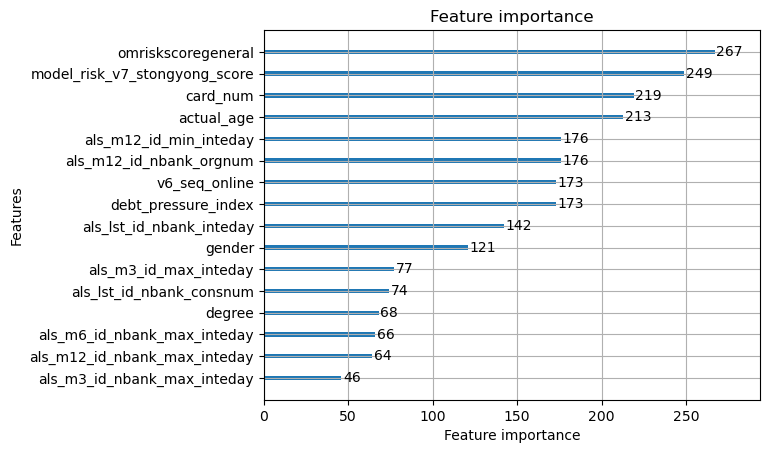

In [60]:
lgbm.plot_importance(clf)

In [62]:
train.query('order_status_key == 1')[['model_risk_v7_stongyong_score', 'omriskscoregeneral']].describe()

,model_risk_v7_stongyong_score,omriskscoregeneral
count,1427.000000,1427.000000
mean,30.716188,728.392432
std,14.867957,83.469516
min,4.000000,459.000000
25%,19.000000,667.000000
50%,29.000000,730.000000
75%,40.000000,790.000000
max,81.000000,900.000000


In [72]:
test.columns

Index(['model_risk_v7_stongyong_score', 'omriskscoregeneral',
       'als_m12_id_nbank_orgnum', 'debt_pressure_index', 'v6_seq_online',
       'als_lst_id_nbank_inteday', 'als_m3_id_nbank_max_inteday',
       'als_m6_id_nbank_max_inteday', 'als_lst_id_nbank_consnum',
       'als_m12_id_nbank_max_inteday', 'als_m3_id_max_inteday',
       'als_m12_id_min_inteday', 'actual_age', 'gender', 'degree', 'card_num',
       'order_status_key', 'score', 'score_rank', 'percentile'],
      dtype='object')

In [80]:
use_cols = ['customer_phone','model_risk_v7_stongyong_score', 'omriskscoregeneral',
       'als_m12_id_nbank_orgnum', 'debt_pressure_index', 'v6_seq_online',
       'als_lst_id_nbank_inteday', 'als_m3_id_nbank_max_inteday',
       'als_m6_id_nbank_max_inteday', 'als_lst_id_nbank_consnum',
       'als_m12_id_nbank_max_inteday', 'als_m3_id_max_inteday',
       'als_m12_id_min_inteday', 'actual_age', 'gender', 'degree', 'card_num',
       'order_status_key']
data = pd.read_csv(config.DATA)[use_cols]

In [95]:
data.query('model_risk_v7_stongyong_score == 68 & omriskscoregeneral == 586')

,customer_phone,model_risk_v7_stongyong_score,omriskscoregeneral,als_m12_id_nbank_orgnum,debt_pressure_index,v6_seq_online,als_lst_id_nbank_inteday,als_m3_id_nbank_max_inteday,als_m6_id_nbank_max_inteday,als_lst_id_nbank_consnum,als_m12_id_nbank_max_inteday,als_m3_id_max_inteday,als_m12_id_min_inteday,actual_age,gender,degree,card_num,order_status_key
4523,d3b1de34834f02b24567197de29adf62,68.0,586.0,5.0,31.0,46.0,81.0,0.0,20.0,3.0,205.0,0.0,0.0,24.0,male,大学专科,无信用卡,3
5434,59a204e3ff3112ed127743429f829302,68.0,586.0,5.0,27.0,53.0,25.0,0.0,68.0,2.0,141.0,0.0,0.0,26.0,male,高中及以下,2张,2


In [77]:
br_duotou = pd.read_csv("/sda/huweipeng/project/长安银行/data/third_party_data/百融数据/样本量10000/详细匹配数据及字典/借贷意向验证-V2.0.csv", header=1, parse_dates=['申请日期'])
customer = pd.read_csv("/sda/huweipeng/project/长安银行/data/third_party_data/百融数据/百融样本.csv", parse_dates=['申请日期'])
br_duotou['customer_phone'] = customer['手机号']
br_duotou = br_duotou[br_duotou['产品输出标识'] == 1]

In [97]:
br_duotou.query('customer_phone == "59a204e3ff3112ed127743429f829302"')[['按身份证号查询，近3个月在非银机构申请最大间隔天数']]

,按身份证号查询，近3个月在非银机构申请最大间隔天数
5433,NaN


In [98]:
train.columns

Index(['model_risk_v7_stongyong_score', 'omriskscoregeneral',
       'als_m12_id_nbank_orgnum', 'debt_pressure_index', 'v6_seq_online',
       'als_lst_id_nbank_inteday', 'als_m3_id_nbank_max_inteday',
       'als_m6_id_nbank_max_inteday', 'als_lst_id_nbank_consnum',
       'als_m12_id_nbank_max_inteday', 'als_m3_id_max_inteday',
       'als_m12_id_min_inteday', 'actual_age', 'gender', 'degree', 'card_num',
       'order_status_key', 'fold'],
      dtype='object')